<a href="https://colab.research.google.com/github/DrakeData/House_Price_EDA/blob/sandbox/MSDS422_Assignment_2_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - House Prices: Advanced Regression Techniques

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from numpy import array
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Lasso

%matplotlib inline
sns.set()

## Import Data
'train_clean.csv' and 'test_clean.csv' is the cleaned up trained data set that worked on in Assignment 1.

In [2]:
df_train = pd.read_csv('./drive/MyDrive/Colab Notebooks/House_Price_EDA/data/train_clean.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSqft,TotalBath,HouseAge,ReModeled
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,2566,3.5,5,0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,0,1262,0,1,2,0,3,1,TA,6,Typ,1,3,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500,2524,2.5,31,0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,3,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,2706,3.5,7,1
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,4,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000,2473,2.0,91,1
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,3,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000,3343,3.5,8,0


In [3]:
df_test = pd.read_csv('./drive/MyDrive/Colab Notebooks/House_Price_EDA/data/test_clean.csv')
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSqft,TotalBath,HouseAge,ReModeled
0,1461,20,RH,80.0,11622,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,...,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,0,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,None,MnPrv,None,0,6,2010,WD,Normal,1778.0,1.0,49,0
1,1462,20,RL,81.0,14267,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,...,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,0,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,None,None,Gar2,12500,6,2010,WD,Normal,2658.0,1.5,52,0
2,1463,60,RL,74.0,13830,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,...,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,3,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,None,MnPrv,None,0,3,2010,WD,Normal,2557.0,2.5,13,1
3,1464,60,RL,78.0,9978,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,...,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,4,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,None,None,None,0,6,2010,WD,Normal,2530.0,2.5,12,0
4,1465,120,RL,43.0,5005,Pave,None,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,...,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,0,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,None,None,None,0,1,2010,WD,Normal,2560.0,2.0,18,0


## Data Check

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 85 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1458 non-null   int64  
 1   MSSubClass     1458 non-null   int64  
 2   MSZoning       1458 non-null   object 
 3   LotFrontage    1458 non-null   float64
 4   LotArea        1458 non-null   int64  
 5   Street         1458 non-null   object 
 6   Alley          1458 non-null   object 
 7   LotShape       1458 non-null   object 
 8   LandContour    1458 non-null   object 
 9   Utilities      1458 non-null   object 
 10  LotConfig      1458 non-null   object 
 11  LandSlope      1458 non-null   object 
 12  Neighborhood   1458 non-null   object 
 13  Condition1     1458 non-null   object 
 14  Condition2     1458 non-null   object 
 15  BldgType       1458 non-null   object 
 16  HouseStyle     1458 non-null   object 
 17  OverallQual    1458 non-null   int64  
 18  OverallC

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 84 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   object 
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          1459 non-null   object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1459 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

## Prep the data for analysis
Filter data to look at significant features and remove the features with a correlation score greater than 0.5 with SalePrice

In [6]:
corr_mat = df_train.corr()
corr_mat['SalePrice'][(corr_mat["SalePrice"] > 0.50)]

OverallQual     0.795774
YearBuilt       0.523608
YearRemodAdd    0.507717
TotalBsmtSF     0.651153
1stFlrSF        0.631530
GrLivArea       0.734968
FullBath        0.562165
TotRmsAbvGrd    0.537769
FireplaceQu     0.521144
GarageYrBlt     0.508719
GarageCars      0.641047
GarageArea      0.629217
SalePrice       1.000000
TotalSqft       0.832877
TotalBath       0.635896
Name: SalePrice, dtype: float64

In [7]:
important_num_cols = list(corr_mat['SalePrice'][(corr_mat["SalePrice"] > 0.5)].index)

important_num_cols.remove('SalePrice')
len(important_num_cols)
print(important_num_cols)

['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'TotalSqft', 'TotalBath']


In [8]:
x_num_only = df_train[important_num_cols]
x_num_only.shape

(1458, 14)

Look at the features that are highly correlated with each other and drop them from our analysis.
We do this so to remove the 'noise' from our data as it will impact our regression model by feeding it the same information.

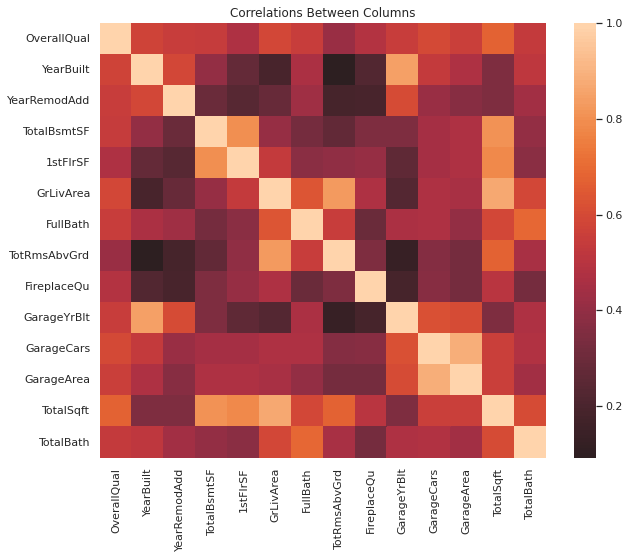

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(x_num_only.corr(), center = 0)
plt.title("Correlations Between Columns")
plt.show()

In [10]:
corr_x = x_num_only.corr()

for i in range(0, len(corr_x) - 1):
    for j in range(i + 1, len(corr_x)):
        if(corr_x.iloc[i, j] < -0.6 or corr_x.iloc[i, j] > 0.6):
            print(f"corr: {corr_x.iloc[i, j]}, row: {i}, column: {j}; {corr_x.index[i]}, {corr_x.index[j]}")

corr: 0.6007408233586187, row: 0, column: 10; OverallQual, GarageCars
corr: 0.677324662815223, row: 0, column: 12; OverallQual, TotalSqft
corr: 0.8448398583188299, row: 1, column: 9; YearBuilt, GarageYrBlt
corr: 0.6036359426335961, row: 2, column: 9; YearRemodAdd, GarageYrBlt
corr: 0.8038296279256137, row: 3, column: 4; TotalBsmtSF, 1stFlrSF
corr: 0.8063997413782675, row: 3, column: 12; TotalBsmtSF, TotalSqft
corr: 0.7819168108101032, row: 4, column: 12; 1stFlrSF, TotalSqft
corr: 0.6383784637415114, row: 5, column: 6; GrLivArea, FullBath
corr: 0.8294981976715387, row: 5, column: 7; GrLivArea, TotRmsAbvGrd
corr: 0.8663861141668217, row: 5, column: 12; GrLivArea, TotalSqft
corr: 0.6932148078878521, row: 6, column: 13; FullBath, TotalBath
corr: 0.678560717489618, row: 7, column: 12; TotRmsAbvGrd, TotalSqft
corr: 0.6195177230785254, row: 9, column: 10; GarageYrBlt, GarageCars
corr: 0.6030387164134533, row: 9, column: 11; GarageYrBlt, GarageArea
corr: 0.8873044983919205, row: 10, column: 11

In [11]:
# from the information above, we want to drop '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', and 'GarageArea'
num_cols = [i for i in x_num_only.columns if i not in ['1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'GarageArea']]
num_cols

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 'GrLivArea',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageCars',
 'TotalSqft',
 'TotalBath']

In [18]:
# Select the important categorical features to use
cat_cols = ["MSZoning", "Utilities", "BldgType", "Heating", 
            "KitchenQual", "SaleCondition", "LandSlope"]

columns_full_ls = num_cols + cat_cols
columns_full_ls

['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 'GrLivArea',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageCars',
 'TotalSqft',
 'TotalBath',
 'MSZoning',
 'Utilities',
 'BldgType',
 'Heating',
 'KitchenQual',
 'SaleCondition',
 'LandSlope']

In [19]:
# Update 'YearRemodAdd' to show how long it has been for when the house was built and when it was remodeled
# disabling the pandas warning
pd.options.mode.chained_assignment = None

df_train['YearRemodAdd'] = df_train['YearRemodAdd'] - df_train['YearBuilt']
df_test['YearRemodAdd'] = df_test['YearRemodAdd'] - df_test['YearBuilt']

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSqft,TotalBath,HouseAge,ReModeled
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,-2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500,2566,3.5,5,0
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,-1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,0,1262,0,1,2,0,3,1,TA,6,Typ,1,3,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500,2524,2.5,31,0
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,-2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,3,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500,2706,3.5,7,1
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,-1860,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,4,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000,2473,2.0,91,1
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,-2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,3,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000,3343,3.5,8,0


In [27]:
df_train_final = df_train[train_columns_full_ls]
df_test_final = df_test[test_columns_full_ls]
df_train_final

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FireplaceQu,GarageYrBlt,GarageCars,TotalSqft,TotalBath,MSZoning,Utilities,BldgType,Heating,KitchenQual,SaleCondition,LandSlope,SalePrice
0,7,2003,-2003,856,1710,0,2003.0,2,2566,3.5,RL,AllPub,1Fam,GasA,Gd,Normal,Gtl,208500
1,6,1976,-1976,1262,1262,3,1976.0,2,2524,2.5,RL,AllPub,1Fam,GasA,TA,Normal,Gtl,181500
2,7,2001,-2000,920,1786,3,2001.0,2,2706,3.5,RL,AllPub,1Fam,GasA,Gd,Normal,Gtl,223500
3,7,1915,-1860,756,1717,4,1998.0,3,2473,2.0,RL,AllPub,1Fam,GasA,Gd,Abnorml,Gtl,140000
4,8,2000,-2000,1145,2198,3,2000.0,3,3343,3.5,RL,AllPub,1Fam,GasA,Gd,Normal,Gtl,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1453,6,1999,-1998,953,1647,3,1999.0,2,2600,2.5,RL,AllPub,1Fam,GasA,TA,Normal,Gtl,175000
1454,6,1978,-1968,1542,2073,3,1978.0,2,3615,3.0,RL,AllPub,1Fam,GasA,TA,Normal,Gtl,210000
1455,7,1941,-1876,1152,2340,4,1941.0,1,3492,2.0,RL,AllPub,1Fam,GasA,Gd,Normal,Gtl,266500
1456,5,1950,-1904,1078,1078,0,1950.0,1,2156,2.0,RL,AllPub,1Fam,GasA,Gd,Normal,Gtl,142125


In [28]:
for col in columns_full_ls:
    train = sorted(df_train_final[col].unique().tolist())
    test = sorted(df_test_final[col].unique().tolist())
    total = set(train + test)
    df_train_final[col] = pd.Categorical(df_train_final[col], categories=total)
    df_test_final[col] = pd.Categorical(df_test_final[col], categories=total)

In [29]:
df_train_final = pd.get_dummies(df_train_final, columns=cat_cols)
df_test_final = pd.get_dummies(df_test_final, columns=cat_cols)


df_train_final.head()

,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,GrLivArea,FireplaceQu,GarageYrBlt,GarageCars,TotalSqft,TotalBath,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RL,MSZoning_RM,MSZoning_RH,Utilities_NoSeWa,Utilities_AllPub,BldgType_TwnhsE,BldgType_2fmCon,BldgType_Duplex,BldgType_1Fam,BldgType_Twnhs,Heating_Wall,Heating_Grav,Heating_GasA,Heating_GasW,Heating_Floor,Heating_OthW,KitchenQual_Ex,KitchenQual_Gd,KitchenQual_TA,KitchenQual_Fa,SaleCondition_Normal,SaleCondition_AdjLand,SaleCondition_Family,SaleCondition_Alloca,SaleCondition_Partial,SaleCondition_Abnorml,LandSlope_Sev,LandSlope_Gtl,LandSlope_Mod
0,7,2003,-2003,856.0,1710,0,2003.0,2.0,2566.0,3.5,208500,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
1,6,1976,-1976,1262.0,1262,3,1976.0,2.0,2524.0,2.5,181500,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
2,7,2001,-2000,920.0,1786,3,2001.0,2.0,2706.0,3.5,223500,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
3,7,1915,-1860,756.0,1717,4,1998.0,3.0,2473.0,2.0,140000,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
4,8,2000,-2000,1145.0,2198,3,2000.0,3.0,3343.0,3.5,250000,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0


## Normalize the data

In [30]:
# Standardize the numeric columns
ss_train = StandardScaler().fit(df_train_final)
ss_test = StandardScaler().fit(df_test_final)

ss_train.mean_

array([ 6.09396433e+00,  1.97121811e+03, -1.95760219e+03,  1.05253704e+03,
        1.51046571e+03,  1.82235940e+00,  1.97646502e+03,  1.76611797e+00,
        2.55715021e+03,  2.20747599e+00,  1.80932919e+05,  6.85871056e-03,
        4.45816187e-02,  7.88065844e-01,  1.49519890e-01,  1.09739369e-02,
        6.85871056e-04,  9.99314129e-01,  7.81893004e-02,  2.12620027e-02,
        3.56652949e-02,  8.35390947e-01,  2.94924554e-02,  2.74348422e-03,
        4.80109739e-03,  9.78052126e-01,  1.23456790e-02,  6.85871056e-04,
        1.37174211e-03,  6.72153635e-02,  4.01920439e-01,  5.04115226e-01,
        2.67489712e-02,  8.21673525e-01,  2.74348422e-03,  1.37174211e-02,
        8.23045267e-03,  8.43621399e-02,  6.92729767e-02,  8.91632373e-03,
        9.46502058e-01,  4.45816187e-02])

In [32]:
## Split the data into train and test set

x = df_train_final.drop(columns=["SalePrice"], axis=1)
y = df_train_final['SalePrice']


x_train, x_test, y_train, y_test = train_test_split(x, y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1093, 41), (365, 41), (1093,), (365,))

In [33]:
## Run a Linear Regression looking at one feature
x_train_overall_q =x_train[['OverallQual']]
x_test_overall_q =x_test[['OverallQual']]

linreg1 = LinearRegression()
kf = KFold(n_splits=7, shuffle=True)

scores = cross_val_score(linreg1, x_train_overall_q, y_train, cv=kf)
print(scores)
print(f'Mean: {scores.mean()}; SD: {scores.std()}')


linreg1.fit(x_train_overall_q, y_train)
print(f'TRAIN Score: {linreg1.score(x_train_overall_q, y_train)}')
print(f'TEST Score: {linreg1.score(x_test_overall_q, y_test)}')

[0.52973938 0.59836025 0.64175939 0.74174571 0.60890716 0.69709588
 0.6642226 ]
Mean: 0.6402614822136483; SD: 0.06443104640460355
TRAIN Score: 0.640756209562547
TEST Score: 0.6090023390249164


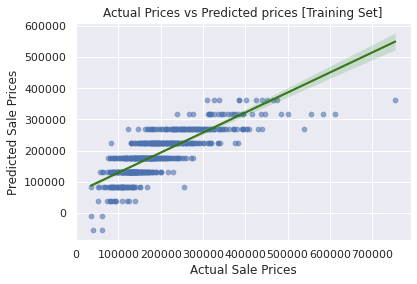

In [38]:
pred = linreg1.predict(x_train_overall_q)
# calculating the intercept and slope for the regression line
b, m = np.polynomial.polynomial.polyfit(y_train, pred, 1)


sns.scatterplot(x=y_train, y=pred, alpha=0.4)
sns.regplot(x=y_train, y=pred, truncate=True, scatter_kws={'s': 20, 'alpha':0.3}, 
            line_kws={'color':'green', 'linewidth': 2})
sns.lineplot(x=np.unique(y_train), y=np.unique(np.poly1d(b + m * np.unique(y_train))), linewidth=0.5, color='r')

plt.xlabel("Actual Sale Prices")
plt.ylabel("Predicted Sale Prices")
plt.title("Actual Prices vs Predicted prices [Training Set]")
 
plt.show()

In [41]:
# Run a Linear Regression looking at multiple feature
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
pred2 = lin_reg.predict(x_train)

kf = KFold(n_splits=7, shuffle=True)

scores = cross_val_score(lin_reg, x_train, y_train, cv=kf)
print(scores)
print(f'Mean: {scores.mean()}; SD: {scores.std()}')


lin_reg.fit(x_train, y_train)
print(f'TRAIN Score: {lin_reg.score(x_train, y_train)}')

print(f'TEST Score: {lin_reg.score(x_test, y_test)}')


# calculating the intercept and slope for the regression line
b, m = np.polynomial.polynomial.polyfit(y_train, pred2, 1)

[0.83519205 0.87439777 0.81043652 0.86064104 0.85664121 0.85858115
 0.87116516]
Mean: 0.8524364140997334; SD: 0.02076115932985314
TRAIN Score: 0.8638122385377193
TEST Score: 0.8457855110866129


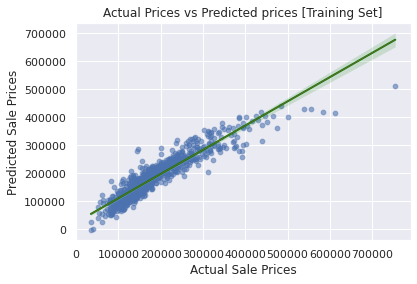

In [43]:
sns.scatterplot(x=y_train, y=pred2, alpha=0.4)
sns.regplot(x=y_train, y=pred2, truncate=True, scatter_kws={'s': 20, 'alpha':0.3}, 
            line_kws={'color':'green', 'linewidth': 2})
sns.lineplot(x=np.unique(y_train), y=np.unique(np.poly1d(b + m * np.unique(y_train))), linewidth=0.5, color='r')

plt.xlabel("Actual Sale Prices")
plt.ylabel("Predicted Sale Prices")
plt.title("Actual Prices vs Predicted prices [Training Set]")
 
plt.show()

In [48]:
predict = lin_reg.predict(df_test_final)
submit = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': predict})
submit

#export to csv
submit.to_csv('./drive/MyDrive/Colab Notebooks/House_Price_EDA/submission.csv',index=False)